# Versions

* version 021 - optimization version: [version 07](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=86475303), optimization rmse: 0.9079, **lb: 0.138**, cv method: GroupKFold
```
lgbm group 5 folds mean rmse: 0.9087, mean pearsonr: 0.1578, mean pearsonr by time_id: 0.1551
lgbm group 5 folds holdout rmse: 0.8967, holdout pearsonr: 0.2222, mean pearsonr by time_id: 0.2152
```
* version 022 - optimization version: [version 08](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=86516619), optimization rmse: 0.9095, **lb: 0.101**, cv method: **TimeSeriesSplit**
```
lgbm time 5 folds mean rmse: 0.9102, mean pearsonr: 0.1276, mean pearsonr by time_id: 0.1267
lgbm time 5 folds holdout rmse: 0.9027, holdout pearsonr: 0.1917, mean pearsonr by time_id: 0.1871
```
* version 023 - optimization version: [version 09](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=86550266), optimization rmse: 0.9078, **lb: 0.138**, cv method: StratifiedKFold
```
lgbm stratified 5 folds mean rmse: 0.9099, mean pearsonr: 0.1504, mean pearsonr by time_id: 0.1474
lgbm stratified 5 folds holdout rmse: 0.8967, holdout pearsonr: 0.2238, mean pearsonr by time_id: 0.2156
```
* version 024 - optimization version: [version 07](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=86475303), optimization rmse: 0.9079, **lb: 0.138**, cv method: GroupKFold, features combination
```
lgbm group 5 folds mean rmse: 0.9087, mean pearsonr: 0.1581, mean pearsonr by time_id: 0.1557
lgbm group 5 folds holdout rmse: 0.8965, holdout pearsonr: 0.2237, mean pearsonr by time_id: 0.2166
```
* ~~version 025~~ - optimization version: [version 07](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=86475303), optimization rmse: 0.9079, **lb: 0.xxx**, cv method: GroupKFold, features combination
```
lgbm group 5 folds mean rmse: 0.9084, mean pearsonr: 0.1570, mean pearsonr by time_id: 0.1538
lgbm group 5 folds holdout rmse: 0.8993, holdout pearsonr: 0.2158, mean pearsonr by time_id: 0.2084
```
* version 026 - optimization version: [version 07](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=86475303), optimization rmse: 0.9079, **lb: 0.137**, cv method: GroupKFold, features combination
```
lgbm group 5 folds mean rmse: 0.9088, mean pearsonr: 0.1574, mean pearsonr by time_id: 0.1551
lgbm group 5 folds holdout rmse: 0.8960, holdout pearsonr: 0.2260, mean pearsonr by time_id: 0.2188
```
* version 027 - optimization version: [version 07](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=86475303), optimization rmse: 0.9079, **lb: 0.137**, cv method: GroupKFold, features combination, drop features
```
lgbm group 5 folds mean rmse: 0.9088, mean pearsonr: 0.1577, mean pearsonr by time_id: 0.1554
lgbm group 5 folds holdout rmse: 0.8963, holdout pearsonr: 0.2243, mean pearsonr by time_id: 0.2173
```
* version 028 - optimization version: [version 07](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=86475303), optimization rmse: 0.9079, **lb: 0.098**, cv method: **GroupTimeSeriesSplit**, features combination, drop features
```
lgbm group_time 5 folds mean rmse: 0.9094, mean pearsonr: 0.1318, mean pearsonr by time_id: 0.1320
lgbm group_time 5 folds holdout rmse: 0.9040, holdout pearsonr: 0.1911, mean pearsonr by time_id: 0.1861
```
* version 029 - optimization version: [version 07](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=86475303), optimization rmse: 0.9079, **lb: 0.101**, cv method: **GroupTimeSeriesSplit**, holdout_size: 150, features combination, drop features
```
lgbm group_time 5 folds mean rmse: 0.9123, mean pearsonr: 0.1347, mean pearsonr by time_id: 0.1334
lgbm group_time 5 folds holdout rmse: 0.9030, holdout pearsonr: 0.1944, mean pearsonr by time_id: 0.1889
```
* version 030 - optimization version: [version 07](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=86475303), optimization rmse: 0.9079, **lb: 0.138**, cv method: GroupKFold, features combination, drop features, partial
```
lgbm group 5 folds mean rmse: 0.9102, mean pearsonr: 0.1589, mean pearsonr by time_id: 0.1576
lgbm group 5 folds holdout rmse: 0.8990, holdout pearsonr: 0.2187, mean pearsonr by time_id: 0.2128
```
* version 031 - optimization version: [version 07](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=86475303), optimization rmse: 0.9079, **lb: 0.xxx**, cv method: GroupKFold, features combination, drop features, partial
```
lgbm group 5 folds mean rmse: 0.9102, mean pearsonr: 0.1589, mean pearsonr by time_id: 0.1576
lgbm group 5 folds holdout rmse: 0.8992, holdout pearsonr: 0.2178, mean pearsonr by time_id: 0.2116
```
* version 032 - optimization version: [version 10](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=87015554), optimization rmse: 0.9095, **lb: 0.xxx**, cv method: GroupKFold, features combination, drop features, partial
```
lgbm group 5 folds mean rmse: 0.9106, mean pearsonr: 0.1561, mean pearsonr by time_id: 0.1546
lgbm group 5 folds holdout rmse: 0.9002, holdout pearsonr: 0.2127, mean pearsonr by time_id: 0.2069
```
* version 033 - optimization version: [version 11](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=87089421), optimization pearsonr: 0.1595, **lb: 0.140**, cv method: GroupKFold, features combination, drop features, partial
```
lgbm group 5 folds mean rmse: 0.9095, mean pearsonr: 0.1608, mean pearsonr by time_id: 0.1590
```
* version 034 - optimization version: [version 11](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=87089421), optimization pearsonr: 0.1595, **lb: 0.140**, cv method: KFold, features combination, drop features, partial
```
lgbm kfold 5 folds mean rmse: 0.9124, mean pearsonr: 0.1404, mean pearsonr by time_id: 0.1391
```
    * fixed features order bug: features = list(**sorted**(set(features).difference(set(to_drop))))
* version 035 - optimization version: [version 11](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=87089421), optimization pearsonr: 0.1595, **lb: 0.139**, cv method: KFold, features combination, drop features, partial, remove outliers
```
lgbm kfold 5 folds mean rmse: 0.9122, mean pearsonr: 0.1411, mean pearsonr by time_id: 0.1399
```
* version 036 - optimization version: [version 11](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=87089421), optimization pearsonr: 0.1595, **lb: 0.xxx**, cv method: TimeSeriesSplit, features combination, drop features, partial, remove outliers
```
lgbm time_range 5 folds mean rmse: 0.9118, mean pearsonr: 0.1237, mean pearsonr by time_id: 0.1216
```
    * **TimeSeriesSplit** according to chinese stock market trading days per year 
* version 037 - optimization version: [version 11](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=87089421), optimization pearsonr: 0.1595, **lb: 0.xxx**, cv method: TimeSeriesSplit, features combination, drop features, remove outliers
```
lgbm time_range 5 folds mean rmse: 0.9096, mean pearsonr: 0.1282, mean pearsonr by time_id: 0.1290
```
* version 038 - optimization version: [version 11](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=87089421), optimization pearsonr: 0.1595, **lb: 0.140**, cv method: GroupKFold, features combination, drop features, remove outliers
```
lgbm 5 folds mean rmse: 0.9072725379028233, mean pearsonr: 0.1636024293518668
lgbm group 5 folds mean rmse: 0.9073, mean pearsonr: 0.1636, mean pearsonr by time_id: 0.1613
```
* version 039 - optimization version: [version 11](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=87089421), optimization pearsonr: 0.1595, **lb: 0.121**, cv method: GroupKFold, features combination, drop features, remove outliers
```
lgbm without_investment_id group 5 folds mean rmse: 0.9073, mean pearsonr: 0.1636, mean pearsonr by time_id: 0.1613
lgbm with_investment_id group 5 folds mean rmse: 0.9114, mean pearsonr: 0.1359, mean pearsonr by time_id: 0.1331
```
    * add investment_id model for exists investment_ids
* version 040 - optimization version: [version 11](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=87089421), optimization pearsonr: 0.1595, **lb: 0.140**, cv method: GroupKFold, features combination, drop features, remove outliers
```
lgbm without_investment_id group 5 folds mean rmse: 0.9073, mean pearsonr: 0.1636, mean pearsonr by time_id: 0.1613
lgbm with_investment_id group 5 folds mean rmse: 0.9114, mean pearsonr: 0.1359, mean pearsonr by time_id: 0.1331
```
    * fixed features copy bug: features_backup = **features.copy()**
    * added inference script
* version 041 - optimization version: [version 11](https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization?scriptVersionId=87089421), optimization pearsonr: 0.1595, **lb: 0.140**, cv method: GroupKFold, features combination, drop features, remove outliers
    * Remove feature outliers: [notebook](https://www.kaggle.com/junjitakeshima/ubiquant-simple-lgbm-removing-outliers-en-jp) by @junjitakeshima
* version 042 - just EDA of time_id and chinese stock market trading date
    * Added [chinese-holidays](https://www.kaggle.com/valleyzw/chinese-holidays) dataset
    * Highlighted **2015–2016 Chinese stock market turbulence** - [wikipedia](https://en.wikipedia.org/wiki/2015%E2%80%932016_Chinese_stock_market_turbulence)
* version 043 - just EDA of time_id and chinese stock market trading date
    * Fixed investment_id range bug of imshow: ```[0, 1.0] -> [train.investment_id.min(), train.investment_id.max()]```
* version 044 - just EDA of time_id and chinese stock market trading date
    * Fixed peak ticks bug: `ax0.set_xticks(ticks=_df.iloc[peeks].index.values, minor=True)`

In [1]:
import os
import gc
import sys
import joblib
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime
from argparse import Namespace
from collections import defaultdict
from scipy.signal import find_peaks

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, GroupKFold, train_test_split, KFold

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 64)

def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
args = Namespace(
    train=True,
    debug=False,
    seed=21,
    folds=5,
    workers=4,
    min_time_id=None, 
    holdout=False,
    cv_method="group",
    num_bins=16,
    holdout_size=100,
    outlier_threshold=0.005,
    trading_days_per_year=250,   # chinese stock market trading days per year (roughly)
    add_investment_id_model=False,
    additional_features=True,
    data_path=Path(""),
    just_eda=True,
)
seed_everything(args.seed)

if args.debug:
    setattr(args, 'min_time_id', 1150)

assert args.cv_method in {"kfold", "group", "stratified", "time", "group_time", "time_range"}, "unknown cv method"
assert args.data_path.exists(), "data_path not exists"

In [4]:
%%time
train = pd.read_parquet(args.data_path.joinpath("train_low_mem.parquet"))
assert train.isnull().any().sum() == 0, "null exists."
assert train.row_id.str.extract(r"(?P<time_id>\d+)_(?P<investment_id>\d+)").astype(train.time_id.dtype).equals(train[["time_id", "investment_id"]]), "row_id!=time_id_investment_id"
assert train.time_id.is_monotonic_increasing, "time_id not monotonic increasing"

CPU times: user 7.85 s, sys: 932 ms, total: 8.78 s
Wall time: 8.78 s


# Features EDA + processing

### Maybe outliers

0.10802400507032894

-0.22408594757318495

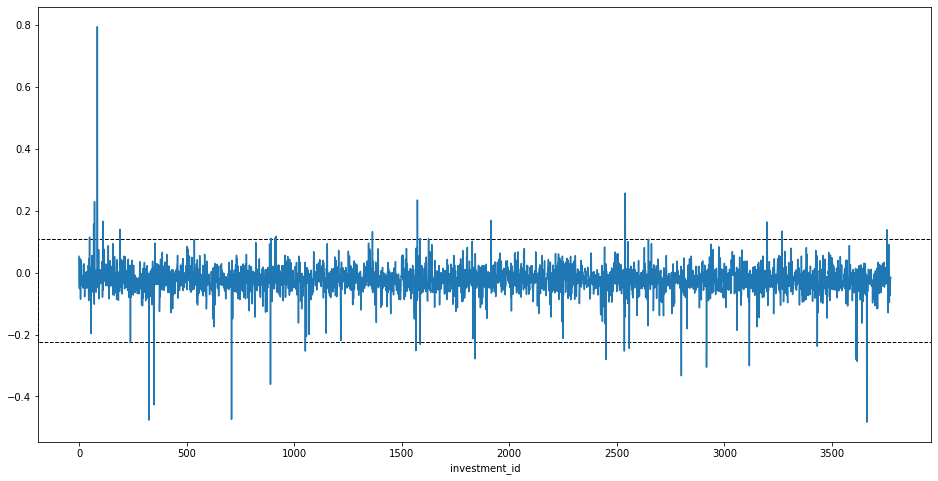

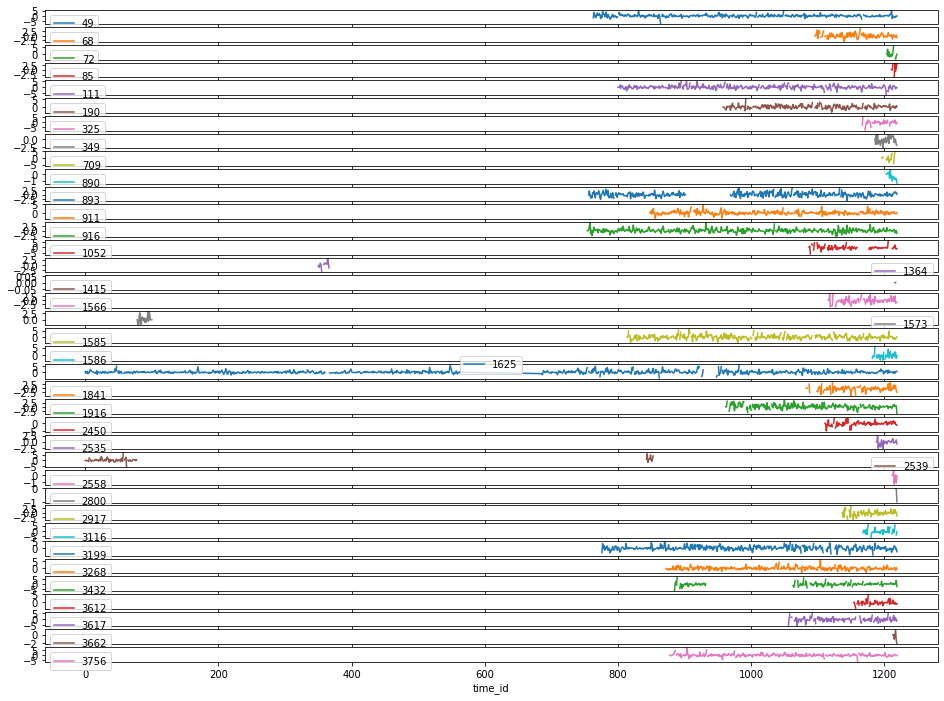

In [5]:
df = train[["investment_id", "target"]].groupby("investment_id").target.mean()
upper_bound, lower_bound = df.quantile([1-args.outlier_threshold, args.outlier_threshold])
display(upper_bound, lower_bound)
ax = df.plot(figsize=(16, 8))
ax.axhspan(lower_bound, upper_bound, fill=False, linestyle="--", color="k")
plt.show()

outlier_investments = df.loc[(df>upper_bound)|(df<lower_bound)|(df==0)].index
_=pd.pivot(
    train.loc[train.investment_id.isin(outlier_investments), ["investment_id", "time_id", "target"]],
    index='time_id', columns='investment_id', values='target'
).plot(figsize=(16,12), subplots=True, sharex=True)

# Drop indexes with feature outliers: [notebook](https://www.kaggle.com/junjitakeshima/ubiquant-simple-lgbm-removing-outliers-en-jp)

In [6]:
outlier_list = []
outlier_col = []

for col in (f"f_{i}" for i in range(300)):
    _mean, _std = train[col].mean(), train[col].std()
    
    temp_df = train.loc[(train[col] > _mean + _std * 70) | (train[col] < _mean - _std * 70)]
    temp2_df = train.loc[(train[col] > _mean + _std * 35) | (train[col] < _mean - _std * 35)]
    if len(temp_df) >0 : 
        outliers = temp_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp_df))
    elif len(temp2_df)>0 and len(temp2_df) <6 :
        outliers = temp2_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp2_df))

outlier_list = list(set(outlier_list))
train.drop(train.index[outlier_list], inplace=True)
print(len(outlier_col), len(outlier_list), train.shape)

f_4 6
f_10 1
f_12 1
f_13 1
f_37 3
f_49 1
f_55 2
f_62 1
f_77 5
f_78 1
f_87 3
f_99 3
f_104 1
f_108 5
f_115 14
f_117 16
f_118 2
f_122 2
f_124 17
f_127 16
f_128 5
f_136 2
f_137 1
f_145 2
f_149 2
f_155 2
f_162 1
f_165 1
f_172 2
f_174 1
f_175 30
f_179 3
f_193 3
f_196 1
f_197 1
f_200 37
f_209 5
f_214 1
f_215 1
f_219 1
f_233 3
f_249 1
f_250 4
f_265 1
f_277 1
f_280 3
f_289 6
f_295 1
48 173 (3141237, 304)


### Drop outliers from train

In [7]:
if args.min_time_id is not None:
    train = train.query("time_id>=@args.min_time_id").reset_index(drop=True)
    gc.collect()
    
train=train.loc[~train.investment_id.isin(outlier_investments)].reset_index(drop=True)
train.shape

(3134708, 304)

### Strange behaviour of some features according to time id

### f_1

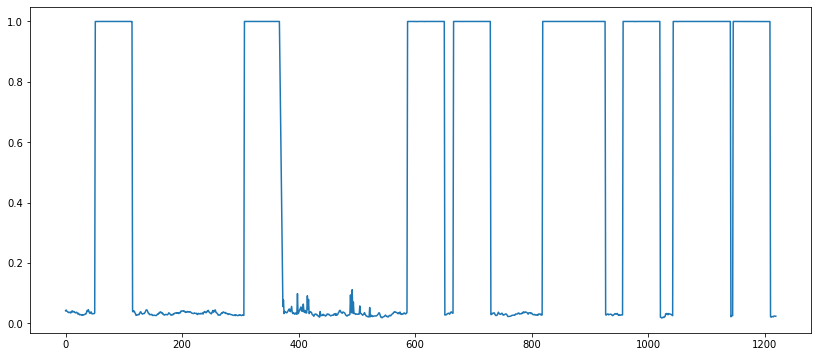

In [20]:
def get_unique_total_values_ratio(df, feature, plot=False, return_result=False):
    df_date_group = df.groupby('time_id').agg({feature: [lambda x: len(x.unique()), 'count']})
    df_date_group.columns.set_levels(['len_unique','count'], level=1,inplace=True)
    df_date_group['unique_count_ratio'] = df_date_group[feature]['len_unique']/df_date_group[feature]['count']
    df_date_group['num_or_cat'] = df_date_group['unique_count_ratio'].apply(lambda x: 1 if x > 0.5 else 0)
    if plot:
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(111)
        plt.plot(df_date_group.index, df_date_group['unique_count_ratio'] , label="Number of unique investments")
    if return_result:
        return df_date_group['num_or_cat']

get_unique_total_values_ratio(train, 'f_1', plot=True)

### f_6

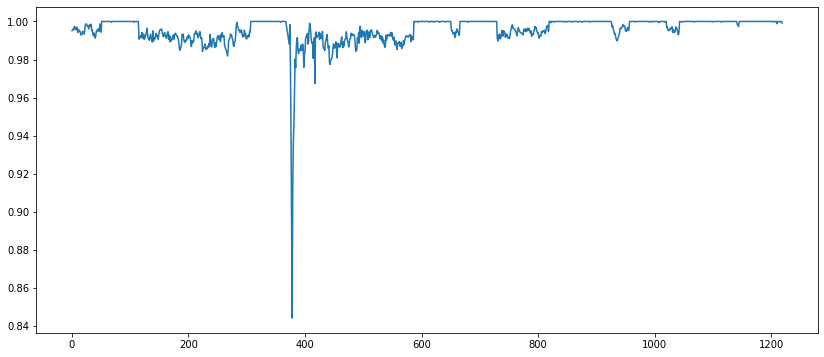

In [10]:
get_unique_total_values_ratio(train, 'f_6', plot=True)

### f_7

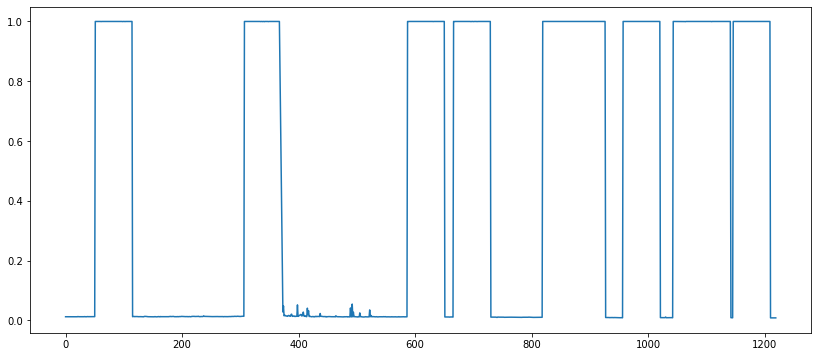

In [21]:
num_or_cat = get_unique_total_values_ratio(train, 'f_7', plot=True, return_result=True)

### Add time_id features

In [13]:
time_id_df = (
    train[["investment_id", "time_id"]]
    .groupby("investment_id")
    .agg(["min", "max", "count", np.ptp])
    .assign(
        time_span=lambda x: x.time_id.ptp,
        time_count=lambda x: x.time_id["count"]
    )
    .drop(columns="ptp", level=1)
    .reset_index()
)
time_id_df.head(6)

investment_id time_id             time_span time_count
                    min   max count                     
0             0     757  1219   461       462        461
1             1       0  1219  1108      1219       1108
2             2       0  1219  1003      1219       1003
3             3      27  1219  1073      1192       1073
4             4     885  1219   316       334        316
5             6       0  1219  1082      1219       1082

### Merge time features with train dataframe

9406

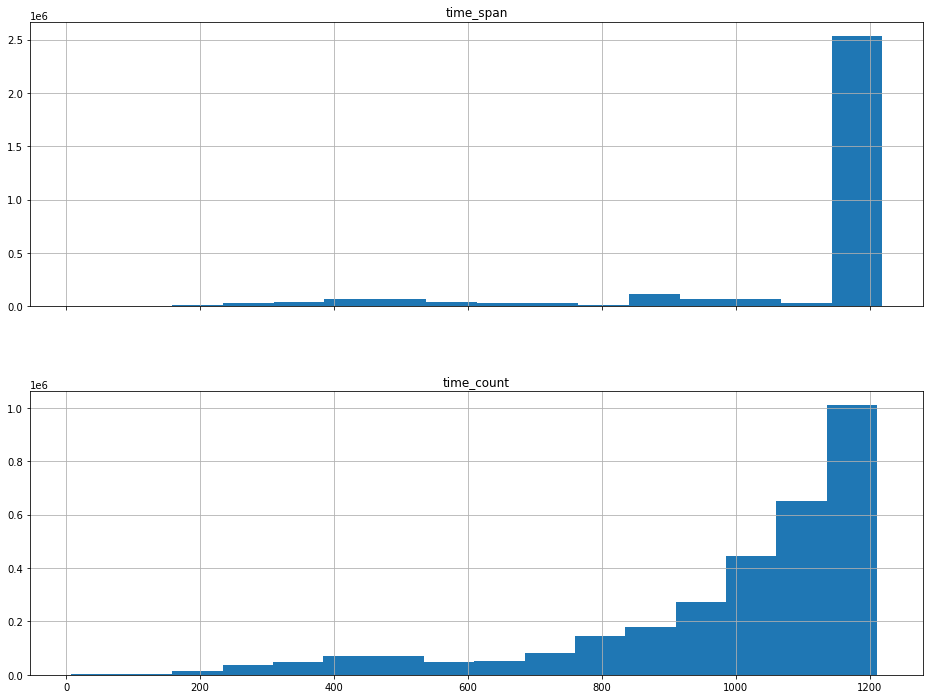

In [15]:
train = train.merge(time_id_df.drop(columns="time_id", level=0).droplevel(level=1, axis=1), on="investment_id", how='left')
train[["time_span", "time_count"]].hist(bins=args.num_bins, figsize=(16,12), sharex=True, layout=(2,1))
max_time_span=time_id_df.time_id["max"].max()
outlier_investments = time_id_df.loc[time_id_df.time_id["count"]<32, "investment_id"].to_list()
del time_id_df
gc.collect()

### Make combinations for some features and drop not necessary features.

In [16]:
cat_features = []
num_features = list(train.filter(like="f_").columns)
features = num_features + cat_features

# make feature combinations
combination_features = ["f_231-f_250", "f_118-f_280", "f_155-f_297", "f_25-f_237", "f_179-f_265", "f_119-f_270", "f_71-f_197", "f_21-f_65"]
for f in combination_features:
    f1, f2 = f.split("-")
    train[f] = train[f1] + train[f2]
features += combination_features

# drop unnecessary features
to_drop = ["f_148", "f_72", "f_49", "f_205", "f_228", "f_97", "f_262", "f_258"]
features = list(sorted(set(features).difference(set(to_drop))))

# add numerical/categorical flag
train = train.merge(num_or_cat, how='left', on='time_id')

# add clusters
# inv_id_to_a_share = pd.read_csv('inv_id_to_a_share.csv')
# train = train.merge(inv_id_to_a_share[['investment_id', 'sector']], how='left', on='investment_id')

# add groups based on time_id
train.loc[(train['time_id'] >= 0) & (train['time_id'] < 280), 'group'] = 0
train.loc[(train['time_id'] >= 280) & (train['time_id'] < 585), 'group'] = 1
train.loc[(train['time_id'] >= 585) & (train['time_id'] < 825), 'group'] = 2
train.loc[(train['time_id'] >= 825) & (train['time_id'] < 1030), 'group'] = 3
train.loc[(train['time_id'] >= 1030) & (train['time_id'] < 1400), 'group'] = 4
train['group'] = train['group'].astype(np.int16)

### Reduce memory usage.

In [14]:
train = reduce_mem_usage(train)
train[["investment_id", "time_id"]] = train[["investment_id", "time_id"]].astype(np.uint16)
train=train.drop(columns=["row_id"]+to_drop)

if args.cv_method=="stratified":
    train["fold"] = train["fold"].astype(np.uint8)
gc.collect()
#features += ["time_id"] # https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302429
features_backup = features.copy()
len(features)

Memory usage of dataframe is 3832.53 MB
Memory usage after optimization is: 2004.68 MB
Decreased by 47.7%


300

# Split + holdout

### StratifiedKFold by time_span: [discussion](https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302429)

In [15]:
# https://www.kaggle.com/joelqv/grouptimeseriescv-catboost-gpu
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """

    @_deprecate_positional_args
    def __init__(self, n_splits=5, *, max_train_size=None):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError("The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if groups[idx] in group_dict:
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                (
                    "Cannot have number of folds={0} greater than"
                    " the number of groups={1}"
                ).format(n_folds, n_groups)
            )
        group_test_size = n_groups // n_folds
        group_test_starts = range(
            n_groups - n_splits * group_test_size, n_groups, group_test_size
        )
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(
                    np.unique(
                        np.concatenate((train_array, train_array_tmp)), axis=None
                    ),
                    axis=None,
                )
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end - self.max_train_size : train_end]
            for test_group_idx in unique_groups[
                group_test_start : group_test_start + group_test_size
            ]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(
                    np.unique(np.concatenate((test_array, test_array_tmp)), axis=None),
                    axis=None,
                )
            yield [int(i) for i in train_array], [int(i) for i in test_array]
            
from sklearn.utils import check_random_state
from sklearn.utils.multiclass import type_of_target
from sklearn.utils.validation import _num_samples, column_or_1d
        
class StratifiedGroupKFold(_BaseKFold):
    """Stratified K-Folds iterator variant with non-overlapping groups.
    This cross-validation object is a variation of StratifiedKFold attempts to
    return stratified folds with non-overlapping groups. The folds are made by
    preserving the percentage of samples for each class.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    The difference between GroupKFold and StratifiedGroupKFold is that
    the former attempts to create balanced folds such that the number of
    distinct groups is approximately the same in each fold, whereas
    StratifiedGroupKFold attempts to create folds which preserve the
    percentage of samples for each class as much as possible given the
    constraint of non-overlapping groups between splits.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.
    shuffle : bool, default=False
        Whether to shuffle each class's samples before splitting into batches.
        Note that the samples within each split will not be shuffled.
        This implementation can only shuffle groups that have approximately the
        same y distribution, no global shuffle will be performed.
    random_state : int or RandomState instance, default=None
        When `shuffle` is True, `random_state` affects the ordering of the
        indices, which controls the randomness of each fold for each class.
        Otherwise, leave `random_state` as `None`.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import StratifiedGroupKFold
    >>> X = np.ones((17, 2))
    >>> y = np.array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    >>> groups = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 8, 8])
    >>> cv = StratifiedGroupKFold(n_splits=3)
    >>> for train_idxs, test_idxs in cv.split(X, y, groups):
    ...     print("TRAIN:", groups[train_idxs])
    ...     print("      ", y[train_idxs])
    ...     print(" TEST:", groups[test_idxs])
    ...     print("      ", y[test_idxs])
    TRAIN: [1 1 2 2 4 5 5 5 5 8 8]
           [0 0 1 1 1 0 0 0 0 0 0]
     TEST: [3 3 3 6 6 7]
           [1 1 1 0 0 0]
    TRAIN: [3 3 3 4 5 5 5 5 6 6 7]
           [1 1 1 1 0 0 0 0 0 0 0]
     TEST: [1 1 2 2 8 8]
           [0 0 1 1 0 0]
    TRAIN: [1 1 2 2 3 3 3 6 6 7 8 8]
           [0 0 1 1 1 1 1 0 0 0 0 0]
     TEST: [4 5 5 5 5]
           [1 0 0 0 0]
    Notes
    -----
    The implementation is designed to:
    * Mimic the behavior of StratifiedKFold as much as possible for trivial
      groups (e.g. when each group contains only one sample).
    * Be invariant to class label: relabelling ``y = ["Happy", "Sad"]`` to
      ``y = [1, 0]`` should not change the indices generated.
    * Stratify based on samples as much as possible while keeping
      non-overlapping groups constraint. That means that in some cases when
      there is a small number of groups containing a large number of samples
      the stratification will not be possible and the behavior will be close
      to GroupKFold.
    See also
    --------
    StratifiedKFold: Takes class information into account to build folds which
        retain class distributions (for binary or multiclass classification
        tasks).
    GroupKFold: K-fold iterator variant with non-overlapping groups.
    """

    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    def _iter_test_indices(self, X, y, groups):
        # Implementation is based on this kaggle kernel:
        # https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
        # and is a subject to Apache 2.0 License. You may obtain a copy of the
        # License at http://www.apache.org/licenses/LICENSE-2.0
        # Changelist:
        # - Refactored function to a class following scikit-learn KFold
        #   interface.
        # - Added heuristic for assigning group to the least populated fold in
        #   cases when all other criteria are equal
        # - Swtch from using python ``Counter`` to ``np.unique`` to get class
        #   distribution
        # - Added scikit-learn checks for input: checking that target is binary
        #   or multiclass, checking passed random state, checking that number
        #   of splits is less than number of members in each class, checking
        #   that least populated class has more members than there are splits.
        rng = check_random_state(self.random_state)
        y = np.asarray(y)
        type_of_target_y = type_of_target(y)
        allowed_target_types = ("binary", "multiclass")
        if type_of_target_y not in allowed_target_types:
            raise ValueError(
                "Supported target types are: {}. Got {!r} instead.".format(
                    allowed_target_types, type_of_target_y
                )
            )

        y = column_or_1d(y)
        _, y_inv, y_cnt = np.unique(y, return_inverse=True, return_counts=True)
        if np.all(self.n_splits > y_cnt):
            raise ValueError(
                "n_splits=%d cannot be greater than the"
                " number of members in each class." % (self.n_splits)
            )
        n_smallest_class = np.min(y_cnt)
        if self.n_splits > n_smallest_class:
            warnings.warn(
                "The least populated class in y has only %d"
                " members, which is less than n_splits=%d."
                % (n_smallest_class, self.n_splits),
                UserWarning,
            )
        n_classes = len(y_cnt)

        _, groups_inv, groups_cnt = np.unique(
            groups, return_inverse=True, return_counts=True
        )
        y_counts_per_group = np.zeros((len(groups_cnt), n_classes))
        for class_idx, group_idx in zip(y_inv, groups_inv):
            y_counts_per_group[group_idx, class_idx] += 1

        y_counts_per_fold = np.zeros((self.n_splits, n_classes))
        groups_per_fold = defaultdict(set)

        if self.shuffle:
            rng.shuffle(y_counts_per_group)

        # Stable sort to keep shuffled order for groups with the same
        # class distribution variance
        sorted_groups_idx = np.argsort(
            -np.std(y_counts_per_group, axis=1), kind="mergesort"
        )

        for group_idx in sorted_groups_idx:
            group_y_counts = y_counts_per_group[group_idx]
            best_fold = self._find_best_fold(
                y_counts_per_fold=y_counts_per_fold,
                y_cnt=y_cnt,
                group_y_counts=group_y_counts,
            )
            y_counts_per_fold[best_fold] += group_y_counts
            groups_per_fold[best_fold].add(group_idx)

        for i in range(self.n_splits):
            test_indices = [
                idx
                for idx, group_idx in enumerate(groups_inv)
                if group_idx in groups_per_fold[i]
            ]
            yield test_indices

    def _find_best_fold(self, y_counts_per_fold, y_cnt, group_y_counts):
        best_fold = None
        min_eval = np.inf
        min_samples_in_fold = np.inf
        for i in range(self.n_splits):
            y_counts_per_fold[i] += group_y_counts
            # Summarise the distribution over classes in each proposed fold
            std_per_class = np.std(y_counts_per_fold / y_cnt.reshape(1, -1), axis=0)
            y_counts_per_fold[i] -= group_y_counts
            fold_eval = np.mean(std_per_class)
            samples_in_fold = np.sum(y_counts_per_fold[i])
            is_current_fold_better = (
                fold_eval < min_eval
                or np.isclose(fold_eval, min_eval)
                and samples_in_fold < min_samples_in_fold
            )
            if is_current_fold_better:
                min_eval = fold_eval
                min_samples_in_fold = samples_in_fold
                best_fold = i
        return best_fold
    
#https://www.kaggle.com/c/ubiquant-market-prediction/discussion/304036
from typing import Tuple
import numpy as np

class GroupTimeSeriesSplit:
    """
    Custom class to create a Group Time Series Split. We ensure
    that the time id values that are in the testing data are not a part
    of the training data & the splits are temporal
    """
    def __init__(self, n_folds: int, holdout_size: int, groups: str) -> None:
        self.n_folds = n_folds
        self.holdout_size = holdout_size
        self.groups = groups

    def split(self, X) -> Tuple[np.array, np.array]:
        # Take the group column and get the unique values
        unique_time_ids = np.unique(self.groups.values)

        # Split the time ids into the length of the holdout size
        # and reverse so we work backwards in time. Also, makes
        # it easier to get the correct time_id values per
        # split
        array_split_time_ids = np.array_split(
            unique_time_ids, len(unique_time_ids) // self.holdout_size
        )[::-1]

        # Get the first n_folds values
        array_split_time_ids = array_split_time_ids[:self.n_folds]

        for time_ids in array_split_time_ids:
            # Get test index - time id values that are in the time_ids
            test_condition = X['time_id'].isin(time_ids)
            test_index = X.loc[test_condition].index

            # Get train index - The train index will be the time
            # id values right up until the minimum value in the test
            # data - we can also add a gap to this step by
            # time id < (min - gap)
            train_condition = X['time_id'] < (np.min(time_ids))
            train_index = X.loc[train_condition].index

            yield train_index, test_index

### Add holdout if needed

In [16]:
if args.holdout:
    _target = pd.cut(train.time_span, args.num_bins, labels=False)
    _train, _valid = train_test_split(_target, stratify=_target, random_state=args.seed)
    print(f"train length: {len(_train)}", f"holdout length: {len(_valid)}")
    valid = train.iloc[_valid.index].sort_values(by=["time_id", "investment_id"]).reset_index(drop=True)
    train = train.iloc[_train.index].sort_values(by=["time_id", "investment_id"]).reset_index(drop=True)
    train.time_span.hist(bins=args.num_bins, figsize=(16,8), alpha=0.8)
    valid.time_span.hist(bins=args.num_bins, figsize=(16,8), alpha=0.8)
    valid.drop(columns="time_span").to_parquet("valid.parquet")
    del valid, _train, _valid, _target
    gc.collect()
assert train.time_id.is_monotonic_increasing, "time_id not monotonic increasing"

### Add Stratified K-fold

In [17]:
if args.cv_method=="stratified":
    train["fold"] = -1
    _target = pd.cut(train.time_span, args.num_bins, labels=False)
    skf = StratifiedKFold(n_splits=args.folds)
    for fold, (train_index, valid_index) in enumerate(skf.split(_target, _target)):
        train.loc[valid_index, 'fold'] = fold

    fig, axs = plt.subplots(nrows=args.folds, ncols=1, sharex=True, figsize=(16,8), tight_layout=True)
    for ax, (fold, df) in zip(axs, train[["fold", "time_span"]].groupby("fold")):
        ax.hist(df.time_span, bins=args.num_bins)
        ax.text(0, 40000, f"fold: {fold}, count: {len(df)}", fontsize=16)
    plt.show()
    del _target, train_index, valid_index
    _=gc.collect()
# if args.just_eda:
#     sys.exit(0)

### TimeSeriesSplit by time_range

In [18]:
if args.cv_method=="time_range":
    train["time_range"] = pd.cut(train.time_id, bins=int(np.ceil(max_time_span/args.trading_days_per_year)))
    _ = train.time_range.value_counts(sort=False).plot(kind="barh", figsize=(16,8))

In [19]:
# corr_matrix = train.filter(like="f_").corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# # Find features with correlation greater than 0.97
# to_drop = [column for column in upper.columns if any(upper[column] >= 0.97)]
# sorted(to_drop)

# Train

### Set scoring and training functions

In [20]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# TODO: replace with feval_pearsonr
def feval_rmse(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'rmse', rmse(y_true, y_pred), False

# https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302480
def feval_pearsonr(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'pearsonr', pearsonr(y_true, y_pred)[0], True

# https://www.kaggle.com/gogo827jz/jane-street-supervised-autoencoder-mlp?scriptVersionId=73762661
# weighted average as per Donate et al.'s formula
# https://doi.org/10.1016/j.neucom.2012.02.053
# [0.0625, 0.0625, 0.125, 0.25, 0.5] for 5 fold
def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return np.average(a, weights = w)

def run(info):    
    # hyperparams from: https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization
    params = {
        'learning_rate':0.05,
        "objective": "regression",
        "metric": "rmse",
        'boosting_type': "gbdt",
        'verbosity': -1,
        'n_jobs': -1, 
        'seed': args.seed,
        'lambda_l1': 0.03627602394442367, 
        'lambda_l2': 0.43523855951142926, 
        'num_leaves': 114, 
        'feature_fraction': 0.9505625064462319, 
        'bagging_fraction': 0.9785558707339647, 
        'bagging_freq': 7, 
        'max_depth': -1, 
        'max_bin': 501, 
        'min_data_in_leaf': 374,
        'n_estimators': 1000, 
    }
    
    y = train['target']
    train['preds'] = -1000
    train['preds_no_clip'] = -1000
    scores = defaultdict(list)
    features_importance= []
    
    def run_single_fold(fold, trn_ind, val_ind):
        train_dataset = lgb.Dataset(train.loc[trn_ind, features], y.loc[trn_ind], categorical_feature=cat_features)
        valid_dataset = lgb.Dataset(train.loc[val_ind, features], y.loc[val_ind], categorical_feature=cat_features)
        model = lgb.train(
            params,
            train_set = train_dataset, 
            valid_sets = [train_dataset, valid_dataset], 
            verbose_eval=50,
            early_stopping_rounds=50,
            feval = feval_pearsonr
        )
        joblib.dump(model, f'lgbm_seed{args.seed}_{fold}_{info}.pkl')
        preds = model.predict(train.loc[val_ind, features])
        train.loc[val_ind, "preds_no_clip"] = preds
        preds = preds.clip(lower_bound, upper_bound) # !!!
        train.loc[val_ind, "preds"] = preds
        scores["rmse"].append(rmse(y.loc[val_ind], preds))
        scores["pearsonr"].append(pearsonr(y.loc[val_ind], preds)[0])
        fold_importance_df= pd.DataFrame({'feature': features, 'importance': model.feature_importance(), 'fold': fold})
        features_importance.append(fold_importance_df)
        del train_dataset, valid_dataset, model
        gc.collect()
        
    if args.cv_method=="stratified":
        for fold in range(args.folds):
            print(f"=====================fold: {fold}=====================")
            trn_ind, val_ind = train.fold!=fold, train.fold==fold
            print(f"train length: {trn_ind.sum()}, valid length: {val_ind.sum()}")
            run_single_fold(fold, trn_ind, val_ind)
    elif args.cv_method=="time":
        tscv = TimeSeriesSplit(args.folds)
        for fold, (trn_ind, val_ind) in enumerate(tscv.split(train[features])):
            print(f"=====================fold: {fold}=====================")
            print(f"train length: {len(trn_ind)}, valid length: {len(val_ind)}")
            run_single_fold(fold, trn_ind, val_ind)
    elif args.cv_method=="group":
        # https://www.kaggle.com/lucamassaron/eda-target-analysis/notebook
        kfold = GroupKFold(args.folds)
        for fold, (trn_ind, val_ind) in enumerate(kfold.split(train[features], y, train.time_id)):
            print(f"=====================fold: {fold}=====================")
            print(f"train length: {len(trn_ind)}, valid length: {len(val_ind)}")
            run_single_fold(fold, trn_ind, val_ind)
    elif args.cv_method=="group_time":
        # initiate GroupKFold (all investment_id should be in the same fold, we want to predict new investment_id)
        kfold = GroupKFold(args.folds)
        for fold, (trn_ind, val_ind) in enumerate(kfold.split(train[features], groups = train['group'])):
            print(f"=====================fold: {fold}=====================")
            print(f"train length: {len(trn_ind)}, valid length: {len(val_ind)}")
            run_single_fold(fold, trn_ind, val_ind)
    elif args.cv_method=="kfold":
        kfold = KFold(args.folds)
        for fold, (trn_ind, val_ind) in enumerate(kfold.split(train[features], train.investment_id)):
            print(f"=====================fold: {fold}=====================")
            print(f"train length: {len(trn_ind)}, valid length: {len(val_ind)}")
            run_single_fold(fold, trn_ind, val_ind)
    # TODO: add another fold to train with the whole training dataset with a tiny learning rate
    elif args.cv_method=="time_range":
        ranges = train.time_range.unique()
        kfold = TimeSeriesSplit(n_splits=args.folds-1)
        for fold, (trn_ind, val_ind) in enumerate(kfold.split(ranges)):
            trn_ind, val_ind = train.time_range.isin(ranges[trn_ind]), train.time_range.isin(ranges[val_ind])
            assert trn_ind.idxmin()-1 < val_ind.idxmax()
            print(f"train length: {trn_ind.sum()}, valid length: {val_ind.sum()}")
            run_single_fold(fold, trn_ind, val_ind)
        
    print(f"lgbm {info} {args.folds} folds mean rmse: {np.mean(scores['rmse'])}, mean pearsonr: {np.mean(scores['pearsonr'])}")
    if "time" in args.cv_method:
        print(f"lgbm {info} {args.folds} folds weighted mean rmse: {weighted_average(scores['rmse'])}, weighted mean pearsonr: {weighted_average(scores['pearsonr'])}")
    train.filter(regex=r"^(?!f_).*").to_csv(f"preds_{info}.csv", index=False)
    return pd.concat(features_importance, axis=0)

### Train without investment_id

=====================fold: 0=====================
train length: 2507859, valid length: 626849
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.905164	training's pearsonr: 0.188888	valid_1's rmse: 0.913177	valid_1's pearsonr: 0.129465
[100]	training's rmse: 0.898397	training's pearsonr: 0.231981	valid_1's rmse: 0.911339	valid_1's pearsonr: 0.142571
[150]	training's rmse: 0.892712	training's pearsonr: 0.263916	valid_1's rmse: 0.91027	valid_1's pearsonr: 0.149859
[200]	training's rmse: 0.887623	training's pearsonr: 0.288799	valid_1's rmse: 0.90965	valid_1's pearsonr: 0.153806
[250]	training's rmse: 0.882961	training's pearsonr: 0.309954	valid_1's rmse: 0.909295	valid_1's pearsonr: 0.156019
[300]	training's rmse: 0.878825	training's pearsonr: 0.327732	valid_1's rmse: 0.909064	valid_1's pearsonr: 0.157498
[350]	training's rmse: 0.874877	training's pearsonr: 0.343692	valid_1's rmse: 0.908908	valid_1's pearsonr: 0.158537
[400]	training's rmse: 0.871509	trai

[350]	training's rmse: 0.87585	training's pearsonr: 0.341921	valid_1's rmse: 0.906322	valid_1's pearsonr: 0.164979
[400]	training's rmse: 0.872323	training's pearsonr: 0.355878	valid_1's rmse: 0.906177	valid_1's pearsonr: 0.165866
[450]	training's rmse: 0.869124	training's pearsonr: 0.36793	valid_1's rmse: 0.906026	valid_1's pearsonr: 0.166827
[500]	training's rmse: 0.866304	training's pearsonr: 0.379151	valid_1's rmse: 0.905919	valid_1's pearsonr: 0.167525
[550]	training's rmse: 0.863578	training's pearsonr: 0.389277	valid_1's rmse: 0.905806	valid_1's pearsonr: 0.168265
[600]	training's rmse: 0.860867	training's pearsonr: 0.399083	valid_1's rmse: 0.905737	valid_1's pearsonr: 0.168738
[650]	training's rmse: 0.85827	training's pearsonr: 0.408238	valid_1's rmse: 0.905718	valid_1's pearsonr: 0.168902
[700]	training's rmse: 0.855903	training's pearsonr: 0.416665	valid_1's rmse: 0.905692	valid_1's pearsonr: 0.169124
[750]	training's rmse: 0.853428	training's pearsonr: 0.425126	valid_1's rms

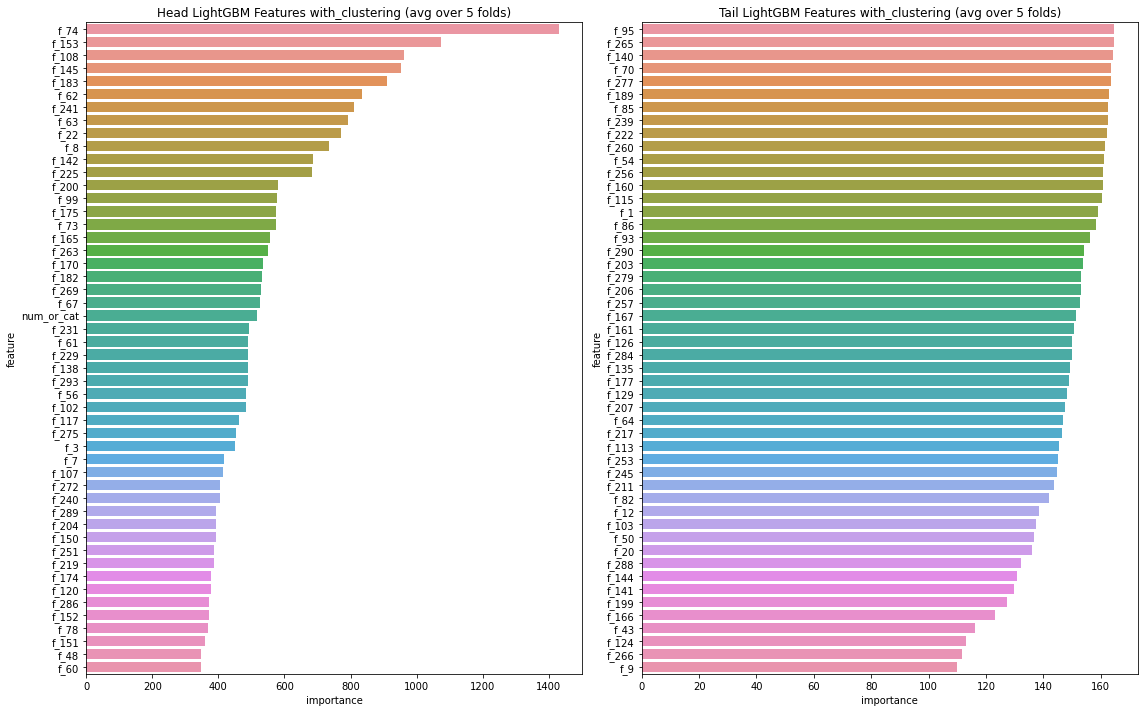

25301

In [21]:
%time

if args.train and args.additional_features:
    cat_features = ["num_or_cat"] # "sector"
    features += cat_features
    info = "with_clustering"
    features_importance = run(info=info)
    df = train[["target", "preds", "time_id"]].query("preds!=-1000")
    score = df.groupby("time_id").apply(lambda x: pearsonr(x.target, x.preds)[0]).mean()
    print(f"lgbm {info} {args.cv_method} {args.folds} folds mean rmse: {rmse(df.target, df.preds):.4f}, mean pearsonr: {pearsonr(df.target, df.preds)[0]:.4f}, mean pearsonr by time_id: {score:.4f}")

    folds_mean_importance = (
        features_importance.groupby("feature", as_index=False)
        .importance.mean()
        .sort_values(by="importance", ascending=False)
    )
    features_importance.to_csv(f"features_importance_{info}.csv", index=False)
    folds_mean_importance.to_csv(f"folds_mean_feature_importance_{info}.csv", index=False)

    plt.figure(figsize=(16, 10))
    plt.subplot(1,2,1)
    sns.barplot(x="importance", y="feature", data=folds_mean_importance.head(50))
    plt.title(f'Head LightGBM Features {info} (avg over {args.folds} folds)')
    plt.subplot(1,2,2)
    sns.barplot(x="importance", y="feature", data=folds_mean_importance.tail(50))
    plt.title(f'Tail LightGBM Features {info} (avg over {args.folds} folds)')
    plt.tight_layout()
    plt.show()
#     del df

# del train
# gc.collect()

In [ ]:
# =====================fold: 0=====================
# train length: 2512449, valid length: 628552
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.906176	training's pearsonr: 0.188518	valid_1's rmse: 0.913584	valid_1's pearsonr: 0.122175
# [100]	training's rmse: 0.89935	training's pearsonr: 0.231927	valid_1's rmse: 0.91191	valid_1's pearsonr: 0.13519
# [150]	training's rmse: 0.893671	training's pearsonr: 0.263512	valid_1's rmse: 0.910935	valid_1's pearsonr: 0.142374
# [200]	training's rmse: 0.888639	training's pearsonr: 0.288379	valid_1's rmse: 0.910383	valid_1's pearsonr: 0.146302
# [250]	training's rmse: 0.884168	training's pearsonr: 0.308646	valid_1's rmse: 0.910032	valid_1's pearsonr: 0.14885
# [300]	training's rmse: 0.879996	training's pearsonr: 0.326463	valid_1's rmse: 0.90979	valid_1's pearsonr: 0.150679
# [350]	training's rmse: 0.876208	training's pearsonr: 0.342131	valid_1's rmse: 0.909587	valid_1's pearsonr: 0.152248
# [400]	training's rmse: 0.872735	training's pearsonr: 0.355814	valid_1's rmse: 0.909406	valid_1's pearsonr: 0.153665
# [450]	training's rmse: 0.869604	training's pearsonr: 0.36795	valid_1's rmse: 0.909286	valid_1's pearsonr: 0.154661
# [500]	training's rmse: 0.866709	training's pearsonr: 0.379061	valid_1's rmse: 0.909255	valid_1's pearsonr: 0.155068
# [550]	training's rmse: 0.863984	training's pearsonr: 0.38926	valid_1's rmse: 0.909145	valid_1's pearsonr: 0.155953
# [600]	training's rmse: 0.861358	training's pearsonr: 0.398672	valid_1's rmse: 0.909053	valid_1's pearsonr: 0.156717
# [650]	training's rmse: 0.858805	training's pearsonr: 0.407944	valid_1's rmse: 0.909006	valid_1's pearsonr: 0.157181
# [700]	training's rmse: 0.856334	training's pearsonr: 0.416659	valid_1's rmse: 0.90896	valid_1's pearsonr: 0.157637
# [750]	training's rmse: 0.853957	training's pearsonr: 0.425024	valid_1's rmse: 0.908915	valid_1's pearsonr: 0.158085
# [800]	training's rmse: 0.851714	training's pearsonr: 0.432439	valid_1's rmse: 0.908868	valid_1's pearsonr: 0.15854
# [850]	training's rmse: 0.849382	training's pearsonr: 0.440221	valid_1's rmse: 0.908863	valid_1's pearsonr: 0.158719
# [900]	training's rmse: 0.847033	training's pearsonr: 0.447681	valid_1's rmse: 0.90889	valid_1's pearsonr: 0.15874
# Early stopping, best iteration is:
# [871]	training's rmse: 0.848436	training's pearsonr: 0.443228	valid_1's rmse: 0.908842	valid_1's pearsonr: 0.158919
# =====================fold: 1=====================
# train length: 2512831, valid length: 628170
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.906398	training's pearsonr: 0.187558	valid_1's rmse: 0.912381	valid_1's pearsonr: 0.152618
# [100]	training's rmse: 0.899663	training's pearsonr: 0.23103	valid_1's rmse: 0.910384	valid_1's pearsonr: 0.162516
# [150]	training's rmse: 0.893989	training's pearsonr: 0.262877	valid_1's rmse: 0.909473	valid_1's pearsonr: 0.166511
# [200]	training's rmse: 0.888967	training's pearsonr: 0.287663	valid_1's rmse: 0.908787	valid_1's pearsonr: 0.16971
# [250]	training's rmse: 0.884295	training's pearsonr: 0.308832	valid_1's rmse: 0.908431	valid_1's pearsonr: 0.171105
# [300]	training's rmse: 0.880187	training's pearsonr: 0.326481	valid_1's rmse: 0.908203	valid_1's pearsonr: 0.171983
# [350]	training's rmse: 0.876476	training's pearsonr: 0.342052	valid_1's rmse: 0.907996	valid_1's pearsonr: 0.172962
# [400]	training's rmse: 0.873057	training's pearsonr: 0.35589	valid_1's rmse: 0.907847	valid_1's pearsonr: 0.173661
# [450]	training's rmse: 0.869911	training's pearsonr: 0.367923	valid_1's rmse: 0.907793	valid_1's pearsonr: 0.173799
# Early stopping, best iteration is:
# [437]	training's rmse: 0.870708	training's pearsonr: 0.36482	valid_1's rmse: 0.907764	valid_1's pearsonr: 0.17403
# =====================fold: 2=====================
# train length: 2512872, valid length: 628129
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.906457	training's pearsonr: 0.190261	valid_1's rmse: 0.911235	valid_1's pearsonr: 0.137748
# [100]	training's rmse: 0.899689	training's pearsonr: 0.232829	valid_1's rmse: 0.909375	valid_1's pearsonr: 0.14954
# [150]	training's rmse: 0.894029	training's pearsonr: 0.264191	valid_1's rmse: 0.908296	valid_1's pearsonr: 0.156312
# [200]	training's rmse: 0.888952	training's pearsonr: 0.28894	valid_1's rmse: 0.907653	valid_1's pearsonr: 0.160003
# [250]	training's rmse: 0.884529	training's pearsonr: 0.309019	valid_1's rmse: 0.907301	valid_1's pearsonr: 0.161925
# [300]	training's rmse: 0.880333	training's pearsonr: 0.32679	valid_1's rmse: 0.907042	valid_1's pearsonr: 0.16341
# [350]	training's rmse: 0.876515	training's pearsonr: 0.342526	valid_1's rmse: 0.906778	valid_1's pearsonr: 0.165043
# [400]	training's rmse: 0.873043	training's pearsonr: 0.356324	valid_1's rmse: 0.906637	valid_1's pearsonr: 0.165917
# [450]	training's rmse: 0.869929	training's pearsonr: 0.368246	valid_1's rmse: 0.906592	valid_1's pearsonr: 0.166209
# [500]	training's rmse: 0.866989	training's pearsonr: 0.379515	valid_1's rmse: 0.90653	valid_1's pearsonr: 0.166638
# [550]	training's rmse: 0.864224	training's pearsonr: 0.389906	valid_1's rmse: 0.906522	valid_1's pearsonr: 0.166743
# Early stopping, best iteration is:
# [507]	training's rmse: 0.866625	training's pearsonr: 0.380865	valid_1's rmse: 0.906508	valid_1's pearsonr: 0.166779
# =====================fold: 3=====================
# train length: 2512956, valid length: 628045
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.906578	training's pearsonr: 0.189438	valid_1's rmse: 0.911293	valid_1's pearsonr: 0.129133
# [100]	training's rmse: 0.899665	training's pearsonr: 0.233156	valid_1's rmse: 0.90957	valid_1's pearsonr: 0.141405
# [150]	training's rmse: 0.894043	training's pearsonr: 0.263784	valid_1's rmse: 0.908639	valid_1's pearsonr: 0.147648
# [200]	training's rmse: 0.888873	training's pearsonr: 0.28905	valid_1's rmse: 0.908181	valid_1's pearsonr: 0.150512
# [250]	training's rmse: 0.884352	training's pearsonr: 0.309558	valid_1's rmse: 0.907736	valid_1's pearsonr: 0.153491
# [300]	training's rmse: 0.880258	training's pearsonr: 0.327042	valid_1's rmse: 0.907568	valid_1's pearsonr: 0.154571
# [350]	training's rmse: 0.876546	training's pearsonr: 0.342198	valid_1's rmse: 0.907345	valid_1's pearsonr: 0.156101
# [400]	training's rmse: 0.873153	training's pearsonr: 0.355634	valid_1's rmse: 0.907176	valid_1's pearsonr: 0.157284
# [450]	training's rmse: 0.870039	training's pearsonr: 0.367819	valid_1's rmse: 0.907138	valid_1's pearsonr: 0.157606
# [500]	training's rmse: 0.867084	training's pearsonr: 0.379121	valid_1's rmse: 0.907076	valid_1's pearsonr: 0.15811
# [550]	training's rmse: 0.864385	training's pearsonr: 0.389471	valid_1's rmse: 0.907031	valid_1's pearsonr: 0.158484
# [600]	training's rmse: 0.861854	training's pearsonr: 0.398884	valid_1's rmse: 0.906996	valid_1's pearsonr: 0.158808
# [650]	training's rmse: 0.859388	training's pearsonr: 0.407656	valid_1's rmse: 0.906945	valid_1's pearsonr: 0.159241
# [700]	training's rmse: 0.856918	training's pearsonr: 0.416432	valid_1's rmse: 0.90693	valid_1's pearsonr: 0.159443
# Early stopping, best iteration is:
# [674]	training's rmse: 0.85819	training's pearsonr: 0.411833	valid_1's rmse: 0.90692	valid_1's pearsonr: 0.159452
# =====================fold: 4=====================
# train length: 2512896, valid length: 628105
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.907009	training's pearsonr: 0.189199	valid_1's rmse: 0.909499	valid_1's pearsonr: 0.139792
# [100]	training's rmse: 0.900131	training's pearsonr: 0.232662	valid_1's rmse: 0.907629	valid_1's pearsonr: 0.151191
# [150]	training's rmse: 0.894336	training's pearsonr: 0.264996	valid_1's rmse: 0.906752	valid_1's pearsonr: 0.156139
# [200]	training's rmse: 0.88924	training's pearsonr: 0.289857	valid_1's rmse: 0.906258	valid_1's pearsonr: 0.158731
# [250]	training's rmse: 0.884691	training's pearsonr: 0.310226	valid_1's rmse: 0.905903	valid_1's pearsonr: 0.160698
# [300]	training's rmse: 0.880586	training's pearsonr: 0.32756	valid_1's rmse: 0.905609	valid_1's pearsonr: 0.16242
# [350]	training's rmse: 0.8768	training's pearsonr: 0.343072	valid_1's rmse: 0.905379	valid_1's pearsonr: 0.163817
# [400]	training's rmse: 0.873389	training's pearsonr: 0.356681	valid_1's rmse: 0.905193	valid_1's pearsonr: 0.164972
# [450]	training's rmse: 0.870175	training's pearsonr: 0.369124	valid_1's rmse: 0.90513	valid_1's pearsonr: 0.165359
# [500]	training's rmse: 0.86728	training's pearsonr: 0.380126	valid_1's rmse: 0.90507	valid_1's pearsonr: 0.165762
# [550]	training's rmse: 0.86444	training's pearsonr: 0.390778	valid_1's rmse: 0.90501	valid_1's pearsonr: 0.166179
# [600]	training's rmse: 0.86179	training's pearsonr: 0.40032	valid_1's rmse: 0.904948	valid_1's pearsonr: 0.16661
# [650]	training's rmse: 0.859092	training's pearsonr: 0.40984	valid_1's rmse: 0.90485	valid_1's pearsonr: 0.167286
# [700]	training's rmse: 0.856642	training's pearsonr: 0.418085	valid_1's rmse: 0.904775	valid_1's pearsonr: 0.167813
# [750]	training's rmse: 0.854228	training's pearsonr: 0.426344	valid_1's rmse: 0.904755	valid_1's pearsonr: 0.168007
# [800]	training's rmse: 0.851856	training's pearsonr: 0.434338	valid_1's rmse: 0.904742	valid_1's pearsonr: 0.168155
# [850]	training's rmse: 0.849501	training's pearsonr: 0.441956	valid_1's rmse: 0.904697	valid_1's pearsonr: 0.16851
# [900]	training's rmse: 0.847187	training's pearsonr: 0.44928	valid_1's rmse: 0.904692	valid_1's pearsonr: 0.16862
# [950]	training's rmse: 0.844981	training's pearsonr: 0.456119	valid_1's rmse: 0.90465	valid_1's pearsonr: 0.168955
# [1000]	training's rmse: 0.842951	training's pearsonr: 0.462477	valid_1's rmse: 0.904622	valid_1's pearsonr: 0.169207
# Did not meet early stopping. Best iteration is:
# [1000]	training's rmse: 0.842951	training's pearsonr: 0.462477	valid_1's rmse: 0.904622	valid_1's pearsonr: 0.169207
# lgbm with_clustering 5 folds mean rmse: 0.9069313069280192, mean pearsonr: 0.1656773409071835
# lgbm with_clustering group 5 folds mean rmse: 0.9069, mean pearsonr: 0.1654, mean pearsonr by time_id: 0.1627

### Train with investment_id features

In [ ]:
if args.add_investment_id_model:
    cat_features = ["investment_id"]
    features += cat_features
    info = "with_investment_id"
    features_importance = run(info=info)
    df = train[["target", "preds", "time_id"]].query("preds!=-1000")
    score = df.groupby("time_id").apply(lambda x: pearsonr(x.target, x.preds)[0]).mean()
    print(f"lgbm {info} {args.cv_method} {args.folds} folds mean rmse: {rmse(df.target, df.preds):.4f}, mean pearsonr: {pearsonr(df.target, df.preds)[0]:.4f}, mean pearsonr by time_id: {score:.4f}")

    folds_mean_importance = (
        features_importance.groupby("feature", as_index=False)
        .importance.mean()
        .sort_values(by="importance", ascending=False)
    )
    features_importance.to_csv(f"features_importance_{info}.csv", index=False)
    folds_mean_importance.to_csv(f"folds_mean_feature_importance_{info}.csv", index=False)

    plt.figure(figsize=(16, 10))
    plt.subplot(1,2,1)
    sns.barplot(x="importance", y="feature", data=folds_mean_importance.head(50))
    plt.title(f'Head LightGBM Features {info} (avg over {args.folds} folds)')
    plt.subplot(1,2,2)
    sns.barplot(x="importance", y="feature", data=folds_mean_importance.tail(50))
    plt.title(f'Tail LightGBM Features {info} (avg over {args.folds} folds)')
    plt.tight_layout()
    plt.show()
#     del df

# del train
# gc.collect()

# Inference

- add num_or_cat
- add pred clipping

In [ ]:
import ubiquant
env = ubiquant.make_env()  
iter_test = env.iter_test()

models_without_investment_id=list(map(joblib.load, sorted(Path(".").glob("lgbm_*_without_investment_id.pkl"))))
if args.add_investment_id_model:
    models_with_investment_id=list(map(joblib.load, sorted(Path(".").glob("lgbm_*_with_investment_id.pkl"))))
elif args.additional_features:
    models_with_investment_id=list(map(joblib.load, sorted(Path(".").glob("lgbm_*_additional_features.pkl"))))
    
if args.holdout:
    df = pd.read_parquet("valid.parquet")
    for f in combination_features:
        f1, f2 = f.split("-")
        df[f] = df[f1] + df[f2]
    df["preds"] = np.mean(np.stack([model.predict(df[features_backup]) for model in models_without_investment_id]), axis=0)
    score = df.groupby("time_id").apply(lambda x: pearsonr(x.target, x.preds)[0]).mean()
    print(f"lgbm {args.cv_method} {args.folds} folds holdout rmse: {rmse(df.target, df.preds):.4f}, holdout pearsonr: {pearsonr(df.target, df.preds)[0]:.4f}, mean pearsonr by time_id: {score:.4f}")
    del df
    gc.collect()

# https://www.kaggle.com/c/ubiquant-market-prediction/discussion/305353 
# When making predictions check if the investment_id was in the train set
for (test_df, sample_prediction_df) in iter_test:
    # get feature combinations
    for f in combination_features:
        f1, f2 = f.split("-")
        test_df[f] = test_df[f1] + test_df[f2]
    
    test_df["time_id"] = test_df.row_id.str.split("_", expand=True)[1].astype(np.uint16) # extract time_id from row_id
    test_num_or_cat = get_unique_total_values_ratio(test_df, 'f_7', plot=False, return_result=True)
    test_df = test_df.merge(test_num_or_cat, how='left', on='time_id')
    
    if args.add_investment_id_model:
        with_investment_id_index = test_df.loc[test_df.investment_id.isin(investment_ids)].index
        without_investment_id_index = test_df.loc[~test_df.investment_id.isin(investment_ids)].index
        if len(with_investment_id_index) > 0:
            test_df.loc[with_investment_id_index, "preds"] = np.mean(np.stack([model.predict(test_df.loc[with_investment_id_index, features]) for model in models_with_investment_id]), axis=0)
        if len(without_investment_id_index) > 0:
            test_df.loc[without_investment_id_index, "preds"] = np.mean(np.stack([model.predict(test_df.loc[without_investment_id_index, features_backup]) for model in models_without_investment_id]), axis=0)
    else:
        test_df["preds"] = np.mean(np.stack([model.predict(test_df[features_backup]) for model in models_without_investment_id]), axis=0)
    # clip predictions
    sample_prediction_df['target'] = test_df["preds"].clip(lower_bound, upper_bound) # !!!
    env.predict(sample_prediction_df) 
    display(sample_prediction_df)

# Further ideas


- drop first time ids from dataset 
- drop turbulence time from dataset
- try clustering by features correlation with each other
- add total number of investment ids in previous time period
- use target lags
- target EMA
- try LAMA
- add model stacking

- target encoding according to cluster, time_id
- try counting time slots for each investment_id
- LGBM Imputation

- try custom loss function (for DNN)

# What works for LGBM CV

- define if feature is numerical of categorical at this time period (num_or_cat)
- clipping of target (at 0.5% min/max)

# Inference script

```
import joblib
import numpy as np
import lightgbm as lgb
from pathlib import Path
from argparse import Namespace

args = Namespace(
    seed=21,
    add_investment_id_model=True,
    data_path=Path("../input/ubiquant-market-prediction"),
    model_path=Path("../input/ubiquant-lgbm-baseline")
)

cat_features = []
num_features = [f"f_{i}" for i in range(300)]
features = num_features + cat_features

combination_features = ["f_231-f_250", "f_118-f_280", "f_155-f_297", "f_25-f_237", "f_179-f_265", "f_119-f_270", "f_71-f_197", "f_21-f_65"]
features += combination_features

to_drop = ["f_148", "f_72", "f_49", "f_205", "f_228", "f_97", "f_262", "f_258"]
features = list(sorted(set(features).difference(set(to_drop))))

features_backup = features.copy()

if args.add_investment_id_model:
    cat_features = ["investment_id"]
    features += cat_features
    
investment_ids=[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 257, 258, 259, 260, 261, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 314, 315, 316, 317, 318, 319, 321, 322, 323, 324, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 350, 351, 352, 353, 354, 356, 357, 358, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 453, 454, 455, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 476, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 520, 521, 523, 524, 525, 526, 527, 528, 529, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 542, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 681, 682, 683, 685, 687, 688, 689, 690, 691, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 710, 711, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 854, 855, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 928, 929, 930, 931, 932, 933, 934, 935, 936, 938, 939, 940, 941, 942, 943, 944, 946, 947, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 965, 966, 967, 968, 969, 970, 972, 973, 974, 975, 976, 977, 978, 979, 980, 982, 983, 984, 985, 986, 987, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1044, 1045, 1046, 1047, 1048, 1049, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1344, 1345, 1346, 1347, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1375, 1376, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1416, 1417, 1418, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1865, 1866, 1867, 1868, 1869, 1871, 1872, 1873, 1874, 1875, 1876, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1898, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015, 2016, 2017, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2095, 2096, 2097, 2098, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2163, 2164, 2165, 2166, 2167, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2215, 2216, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2269, 2270, 2271, 2272, 2273, 2274, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2346, 2347, 2348, 2349, 2350, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2365, 2367, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2400, 2401, 2402, 2403, 2404, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2446, 2447, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2505, 2506, 2507, 2509, 2510, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2530, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2583, 2584, 2585, 2586, 2587, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2597, 2598, 2599, 2600, 2601, 2602, 2604, 2605, 2606, 2607, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2676, 2677, 2678, 2680, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2844, 2845, 2846, 2847, 2848, 2849, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2978, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3105, 3106, 3107, 3108, 3109, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3212, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3236, 3237, 3238, 3239, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3319, 3320, 3321, 3322, 3323, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3423, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3544, 3545, 3546, 3547, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3660, 3661, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3682, 3683, 3684, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3772, 3773]

len(features), len(features_backup), len(investment_ids)

import ubiquant
env = ubiquant.make_env()  
iter_test = env.iter_test()

models_without_investment_id=list(map(joblib.load, sorted(args.model_path.glob("lgbm_*_without_investment_id.pkl"))))
if args.add_investment_id_model:
    models_with_investment_id=list(map(joblib.load, sorted(args.model_path.glob("lgbm_*_with_investment_id.pkl"))))
   
# https://www.kaggle.com/c/ubiquant-market-prediction/discussion/305353 
# When making predictions check if the investment_id was in the train set
for (test_df, sample_prediction_df) in iter_test:
    for f in combination_features:
        f1, f2 = f.split("-")
        test_df[f] = test_df[f1] + test_df[f2]
    #test_df["time_id"] = test_df.row_id.str.split("_", expand=True)[1].astype(np.uint16) # extract time_id form row_id
    if args.add_investment_id_model:
        with_investment_id_index = test_df.loc[test_df.investment_id.isin(investment_ids)].index
        without_investment_id_index = test_df.loc[~test_df.investment_id.isin(investment_ids)].index
        if len(with_investment_id_index) > 0:
            test_df.loc[with_investment_id_index, "preds"] = np.mean(np.stack([model.predict(test_df.loc[with_investment_id_index, features]) for model in models_with_investment_id]), axis=0)
        if len(without_investment_id_index) > 0:
            test_df.loc[without_investment_id_index, "preds"] = np.mean(np.stack([model.predict(test_df.loc[without_investment_id_index, features_backup]) for model in models_without_investment_id]), axis=0)
    else:
        test_df["preds"] = np.mean(np.stack([model.predict(test_df[features_backup]) for model in models_without_investment_id]), axis=0)
    sample_prediction_df['target'] = test_df["preds"]
    env.predict(sample_prediction_df) 
    display(sample_prediction_df)
```